#Previsão de visualizações
Iniciamos carregando as biliotecas necessárias.

In [ ]:
!pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AutoReg
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

##Carregamento do dataset escolhido
Fazemos o carregamento e verificação do conteúdo do dataset.

In [ ]:
data_views = pd.read_csv("view_diaria.csv")
data_views.head()

,Data,Visualizações
0,2016-05-10,0
1,2016-05-11,0
2,2016-05-12,0
3,2016-05-13,0
4,2016-05-14,0


In [ ]:
data_views.tail(5)

,Data,Visualizações
2769,2023-12-09,529
2770,2023-12-10,607
2771,2023-12-11,1002
2772,2023-12-12,923
2773,2023-12-13,940


In [ ]:
data_views['Data'] = pd.to_datetime(data_views['Data'])

In [ ]:
data_views = data_views.sort_values(by='Data', ascending = True)

In [ ]:
data_views.shape

(2774, 2)

Separaremos as views em quinzenas, de modo a agregar o número de visualizações.

In [ ]:
import pandas as pd

# Supondo que você já tenha um DataFrame chamado data_views com as colunas Data e Visualizações
# Converta a coluna 'Data' para o tipo datetime
data_views['Data'] = pd.to_datetime(data_views['Data'])

# Função para obter a quinzena e a data de início
def obter_quinzena_e_data_inicio(data):
    start_date = pd.Timestamp('2016-01-01')  # Início do intervalo desejado
    days = (data - start_date).days
    quinzena = (days // 15) + 1
    data_inicio_quinzena = start_date + pd.DateOffset(days=((quinzena - 1) * 15))
    return quinzena, data_inicio_quinzena

# Aplicar a função para obter quinzena e data de início
data_views[['Quinzena', 'Data_Inicio_Quinzena']] = data_views['Data'].apply(obter_quinzena_e_data_inicio).apply(pd.Series)

# Agrupe pelos valores de quinzena e calcular a soma das Visualizações
df_agrupado = data_views.groupby(['Quinzena', 'Data_Inicio_Quinzena']).agg({'Visualizações': 'sum'}).reset_index()

# Ordenar o DataFrame pela coluna 'Data_Inicio_Quinzena'
df_agrupado = df_agrupado.sort_values(by='Data_Inicio_Quinzena')

# Exibir o DataFrame resultante
print(df_agrupado)

     Quinzena Data_Inicio_Quinzena  Visualizações
0           9           2016-04-30              0
1          10           2016-05-15              0
2          11           2016-05-30            112
3          12           2016-06-14            111
4          13           2016-06-29             61
..        ...                  ...            ...
181       190           2023-10-06          10873
182       191           2023-10-21          12011
183       192           2023-11-05          11977
184       193           2023-11-20          16412
185       194           2023-12-05           7455

[186 rows x 3 columns]


In [ ]:
df_agrupado

,Quinzena,Data_Inicio_Quinzena,Visualizações
0,9,2016-04-30,0
1,10,2016-05-15,0
2,11,2016-05-30,112
3,12,2016-06-14,111
4,13,2016-06-29,61
...,...,...,...
181,190,2023-10-06,10873
182,191,2023-10-21,12011
183,192,2023-11-05,11977
184,193,2023-11-20,16412


Abaixo, o código em Python realiza a validação cruzada de séries temporais usando a técnica TimeSeriesSplit com 31 folds. Utilizando a biblioteca pmdarima, o código treina e avalia um modelo ARIMA automaticamente ajustando seus parâmetros em cada fold. As métricas de desempenho (MAE, MSE, RMSE) são calculadas para cada iteração e, em seguida, suas médias são computadas. O código também gera um gráfico comparando as séries temporais reais e previstas. Este processo é aplicado a um conjunto de dados denominado df_agrupado que possui colunas 'data' e 'Visualizações'. O modelo ARIMA é normalizado usando MinMaxScaler, e as previsões são desnormalizadas antes de calcular as métricas de desempenho. O objetivo é fornecer uma avaliação robusta do desempenho do modelo na previsão do número de visualizações ao longo do tempo.

Podemos ver também, comentada, uma versão do código em que as previsões são feitas com dados diários.

In [ ]:
'''
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Supondo que você tenha um dataframe data_views com colunas 'data' e 'visualizacoes'
# Substitua esses nomes de coluna conforme necessário

# Criar uma instância de TimeSeriesSplit com o mesmo critério de definição de folds
tss_2 = TimeSeriesSplit(n_splits= 5)

# Listas para armazenar resultados
mae_list, mse_list, rmse_list = [], [], []
y_teste_list, y_pred_list = [], []

# Iteração sobre os folds
fold = 0
for i_train, i_test in tss_2.split(data_views):
    fold += 1
    train, test = data_views.iloc[i_train], data_views.iloc[i_test]

    # Normalização usando MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train['Visualizações'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test['Visualizações'].values.reshape(-1, 1))

    # Treinar o modelo ARIMA com parâmetros ajustados
    model = auto_arima(train_scaled, suppress_warnings=True, seasonal=False, stepwise=False, trace=False, error_action='ignore', maxiter=99)

    # Ajustar o modelo ARIMA com os melhores parâmetros encontrados
    fit_model = model.fit(train_scaled)

    # Realizar previsões
    y_pred_scaled = fit_model.predict(n_periods=len(test_scaled))

    # Desnormalização
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de visualizações não sejam negativos
    y_pred = np.maximum(y_pred, 0)

    # Calcular métricas
    mae = mean_absolute_error(test['Visualizações'], y_pred)
    mse = mean_squared_error(test['Visualizações'], y_pred)
    rmse = sqrt(mse)

    # Armazenar resultados
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    y_teste_list.extend(test['Visualizações'])
    y_pred_list.extend(y_pred)

# Médias das métricas
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)

# Plotar resultado final
plt.figure(figsize=(10, 6))
plt.plot(y_teste_list, label='Real')
plt.plot(y_pred_list, label='Previsto')
plt.title('Previsão vs Realidade (Média de Todos os Folds)')
plt.xlabel('Índice')
plt.ylabel('Visualizações')
plt.legend()
plt.show()

# Resultados finais
print(f'Média MAE: {mean_mae}')
print(f'Média MSE: {mean_mse}')
print(f'Média RMSE: {mean_rmse}')
'''

"\nimport pandas as pd\nimport numpy as np\nfrom pmdarima import auto_arima\nfrom sklearn.model_selection import TimeSeriesSplit\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\nfrom math import sqrt\nfrom sklearn.preprocessing import MinMaxScaler\nimport matplotlib.pyplot as plt\n\n# Supondo que você tenha um dataframe data_views com colunas 'data' e 'visualizacoes'\n# Substitua esses nomes de coluna conforme necessário\n\n# Criar uma instância de TimeSeriesSplit com o mesmo critério de definição de folds\ntss_2 = TimeSeriesSplit(n_splits= 5)\n\n# Listas para armazenar resultados\nmae_list, mse_list, rmse_list = [], [], []\ny_teste_list, y_pred_list = [], []\n\n# Iteração sobre os folds\nfold = 0\nfor i_train, i_test in tss_2.split(data_views):\n    fold += 1\n    train, test = data_views.iloc[i_train], data_views.iloc[i_test]\n\n    # Normalização usando MinMaxScaler\n    scaler = MinMaxScaler()\n    train_scaled = scaler.fit_transform(train['Visualizações'].valu

Usando os dados quinzenais:

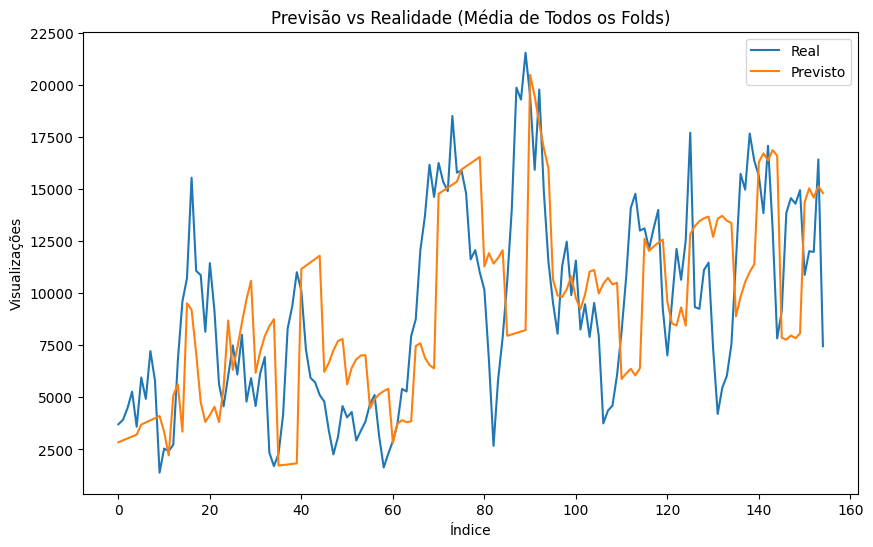

Média MAE: 3604.9905925108474
Média MSE: 20342598.862172253
Média RMSE: 4067.982058849854


In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Supondo que você tenha um dataframe data_views com colunas 'data' e 'visualizacoes'
# Substitua esses nomes de coluna conforme necessário

# Criar uma instância de TimeSeriesSplit com o mesmo critério de definição de folds
tss_2 = TimeSeriesSplit(n_splits= 31)

# Listas para armazenar resultados
mae_list, mse_list, rmse_list = [], [], []
y_teste_list, y_pred_list = [], []

# Iteração sobre os folds
fold = 0
for i_train, i_test in tss_2.split(df_agrupado):
    fold += 1
    train, test = df_agrupado.iloc[i_train], df_agrupado.iloc[i_test]

    # Normalização usando MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train['Visualizações'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test['Visualizações'].values.reshape(-1, 1))

    # Treinar o modelo ARIMA com parâmetros ajustados
    model = auto_arima(train_scaled, suppress_warnings=True, seasonal=False, stepwise=False, trace=False, error_action='ignore', maxiter=99)

    # Ajustar o modelo ARIMA com os melhores parâmetros encontrados
    fit_model = model.fit(train_scaled)

    # Realizar previsões
    y_pred_scaled = fit_model.predict(n_periods=len(test_scaled))

    # Desnormalização
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de visualizações não sejam negativos
    y_pred = np.maximum(y_pred, 0)

    # Calcular métricas
    mae = mean_absolute_error(test['Visualizações'], y_pred)
    mse = mean_squared_error(test['Visualizações'], y_pred)
    rmse = sqrt(mse)

    # Armazenar resultados
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    y_teste_list.extend(test['Visualizações'])
    y_pred_list.extend(y_pred)

# Médias das métricas
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)

# Plotar resultado final
plt.figure(figsize=(10, 6))
plt.plot(y_teste_list, label='Real')
plt.plot(y_pred_list, label='Previsto')
plt.title('Previsão vs Realidade (Média de Todos os Folds)')
plt.xlabel('Índice')
plt.ylabel('Visualizações')
plt.legend()
plt.show()

# Resultados finais
print(f'Média MAE: {mean_mae}')
print(f'Média MSE: {mean_mse}')
print(f'Média RMSE: {mean_rmse}')

## Código mostrando a previsão para os próximos 12 meses
Aqui o processo é repetido, porém agregando a previsão para os próximo ano.

Usando dados diários:

Previsões futuras médias para os próximos 366 meses:
[711.11282379 578.18008002 513.7914832  624.96643667 766.8853997
 823.74349703 797.35137402 709.97842478 600.24312526 571.14134471
 645.64400638 744.99337029 797.67334584 782.54974219 706.19247573
 624.36368119 605.92047406 659.77606662 736.13830297 782.34533828
 769.07012659 705.83852776 642.5472324  628.99183151 670.91820367
 733.69551522 772.3274273  759.87567038 707.01293765 655.91069722
 645.22625293 680.46195126 733.86765254 766.15850732 754.3013927
 708.96345708 665.93811464 657.48016084 688.61492392 735.27659167
 762.72961937 751.37113201 711.32301532 673.90025547 667.22284188
 695.61915362 737.32604027 761.21398403 750.24584794 713.97705501
 680.59824986 675.31157502 701.73020448 739.73784119 760.99414819
 750.34193441 716.87132848 686.51444865 682.28353885 707.18161354
 742.36065645 761.64111396 751.26863454 719.96264726 691.93571268
 688.49370198 712.15898651 745.10777533 762.86794161 752.76564191
 723.2092107  697.0354062

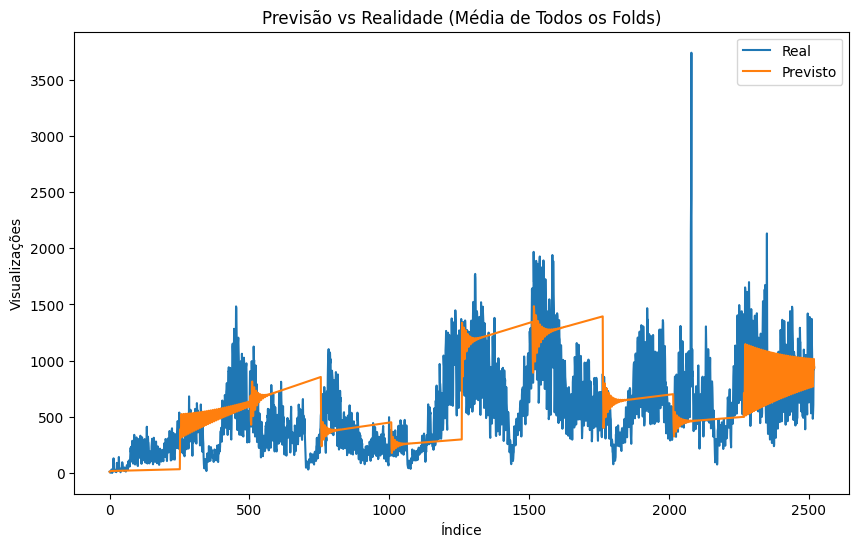

Média MAE: 307.0373411566194
Média MSE: 163197.11379204472
Média RMSE: 379.48883242338354


In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Criar uma instância de TimeSeriesSplit com o mesmo critério de definição de folds
tss_2 = TimeSeriesSplit(n_splits= 10)

# Listas para armazenar resultados
mae_list, mse_list, rmse_list = [], [], []
y_teste_list, y_pred_list = [], []

# Previsões futuras
future_pred_list = []

# Iteração sobre os folds
fold = 0
for i_train, i_test in tss_2.split(data_views):
    fold += 1
    train, test = data_views.iloc[i_train], data_views.iloc[i_test]

    # Normalização usando MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train['Visualizações'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test['Visualizações'].values.reshape(-1, 1))

    # Treinar o modelo ARIMA com parâmetros ajustados
    model = auto_arima(train_scaled, suppress_warnings=True, seasonal=False, stepwise=False, trace=False, error_action='ignore', maxiter=99)

    # Ajustar o modelo ARIMA com os melhores parâmetros encontrados
    fit_model = model.fit(train_scaled)

    # Realizar previsões para os dados de teste
    y_pred_scaled = fit_model.predict(n_periods=len(test_scaled))

    # Desnormalização
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de visualizações não sejam negativos
    y_pred = np.maximum(y_pred, 0)

    # Calcular métricas
    mae = mean_absolute_error(test['Visualizações'], y_pred)
    mse = mean_squared_error(test['Visualizações'], y_pred)
    rmse = sqrt(mse)

    # Armazenar resultados
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    y_teste_list.extend(test['Visualizações'])
    y_pred_list.extend(y_pred)

    # Estender o treinamento para incluir dados de teste
    train_test_combined = np.concatenate((train_scaled, test_scaled))
    fit_model = model.fit(train_test_combined)

    # Fazer previsões para os próximos 12 meses
    future_periods = 366
    future_pred_scaled = fit_model.predict(n_periods=future_periods)

    # Desnormalização das previsões futuras
    future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de visualizações não sejam negativos
    future_pred = np.maximum(future_pred, 0)

    # Armazenar previsões futuras
    future_pred_list.append(future_pred)

# Calcular a média das previsões futuras
mean_future_pred = np.mean(future_pred_list, axis=0)

# Imprimir as previsões futuras médias
print(f"Previsões futuras médias para os próximos {future_periods} meses:")
print(mean_future_pred)

# Médias das métricas
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)

# Plotar resultado final
plt.figure(figsize=(10, 6))
plt.plot(y_teste_list, label='Real')
plt.plot(y_pred_list, label='Previsto')
plt.title('Previsão vs Realidade (Média de Todos os Folds)')
plt.xlabel('Índice')
plt.ylabel('Visualizações')
plt.legend()
plt.show()

# Resultados finais
print(f'Média MAE: {mean_mae}')
print(f'Média MSE: {mean_mse}')
print(f'Média RMSE: {mean_rmse}')

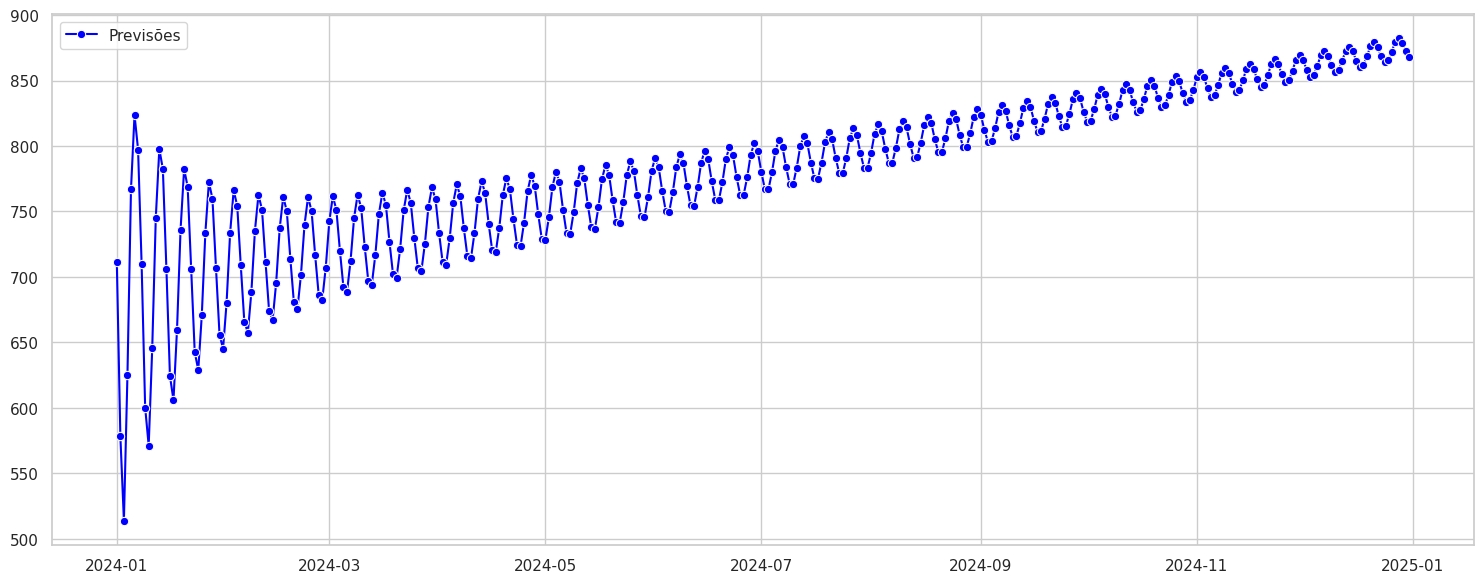

In [ ]:
import seaborn as sns

# Criar um DataFrame com os dados
df = pd.DataFrame({
    'Meses': pd.date_range(start='2024-01-01', end='2024-12-31', freq='1D'),
    'Previsões': mean_future_pred
})

# Configurar o estilo do seaborn
sns.set(style='whitegrid')

# Criar o lineplot
plt.figure(figsize=(15, 6))
sns.lineplot(x='Meses', y='Previsões', data=df, marker='o', color='blue', label='Previsões')

# Adicionar rótulos e título
plt.xlabel('')
plt.ylabel('')
plt.title('')

# Exibir o gráfico
plt.xticks(rotation= 0)
plt.tight_layout()
plt.show()

Previsões futuras para os próximos 12 meses:
[7704.87028709 8174.66616136 8144.69139024 9491.3234744  9541.5089287
 9591.694383   9641.87983729 9692.06529159 9742.25074589 9792.43620019
 9842.62165448 9892.80710878]

Após o agrupamento em quinzena, usamos o máximo de folds possíveis, de modo a ter agora 185 folds:

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/usr/local/lib/python3.10/dist-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


Previsões futuras médias para os próximos 24 meses:
[ 8073.06428495  8162.146958    8297.01274502  8391.18075026
  8496.87930707  8647.95612189  8782.40241139  8912.2716129
  9016.70303762  9074.18243725  9125.35291083  9171.33537508
  9207.09610364  9278.47961605  9355.13158655  9450.16689033
  9576.52076573  9685.77367     9799.53472165  9899.86352997
  9967.24242369 10041.40428839 10101.95712235 10164.50994509]


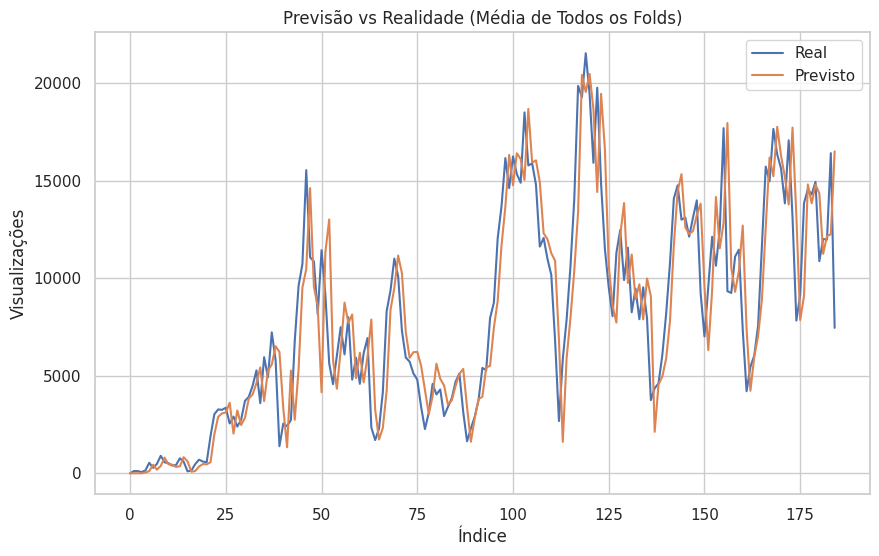

Média MAE: 1824.621694392772
Média MSE: 6436516.440823733
Média RMSE: 1824.621694392772


In [ ]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Supondo que você tenha um dataframe df_agrupado com colunas 'data' e 'Visualizações'
# Substitua esses nomes de coluna conforme necessário

# Criar uma instância de TimeSeriesSplit com o mesmo critério de definição de folds
tss_2 = TimeSeriesSplit(n_splits= 185)

# Listas para armazenar resultados
mae_list, mse_list, rmse_list = [], [], []
y_teste_list, y_pred_list = [], []

# Previsões futuras
future_pred_list = []

# Iteração sobre os folds
fold = 0
for i_train, i_test in tss_2.split(df_agrupado):
    fold += 1
    train, test = df_agrupado.iloc[i_train], df_agrupado.iloc[i_test]

    # Normalização usando MinMaxScaler
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train['Visualizações'].values.reshape(-1, 1))
    test_scaled = scaler.transform(test['Visualizações'].values.reshape(-1, 1))

    # Treinar o modelo ARIMA com parâmetros ajustados
    model = auto_arima(train_scaled, suppress_warnings=True, seasonal=False, stepwise=False, trace=False, error_action='ignore', maxiter=99)

    # Ajustar o modelo ARIMA com os melhores parâmetros encontrados
    fit_model = model.fit(train_scaled)

    # Realizar previsões para os dados de teste
    y_pred_scaled = fit_model.predict(n_periods=len(test_scaled))

    # Desnormalização
    y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de visualizações não sejam negativos
    y_pred = np.maximum(y_pred, 0)

    # Calcular métricas
    mae = mean_absolute_error(test['Visualizações'], y_pred)
    mse = mean_squared_error(test['Visualizações'], y_pred)
    rmse = sqrt(mse)

    # Armazenar resultados
    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    y_teste_list.extend(test['Visualizações'])
    y_pred_list.extend(y_pred)

    # Estender o treinamento para incluir dados de teste
    train_test_combined = np.concatenate((train_scaled, test_scaled))
    fit_model = model.fit(train_test_combined)

    # Fazer previsões para os próximos 12 meses
    future_periods = 24
    future_pred_scaled = fit_model.predict(n_periods=future_periods)

    # Desnormalização das previsões futuras
    future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

    # Certificar-se de que os valores de visualizações não sejam negativos
    future_pred = np.maximum(future_pred, 0)

    # Armazenar previsões futuras
    future_pred_list.append(future_pred)

# Calcular a média das previsões futuras
mean_future_pred = np.mean(future_pred_list, axis=0)

# Imprimir as previsões futuras médias
print(f"Previsões futuras médias para os próximos {future_periods} meses:")
print(mean_future_pred)

# Médias das métricas
mean_mae = np.mean(mae_list)
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)

# Plotar resultado final
plt.figure(figsize=(10, 6))
plt.plot(y_teste_list, label='Real')
plt.plot(y_pred_list, label='Previsto')
plt.title('Previsão vs Realidade (Média de Todos os Folds)')
plt.xlabel('Índice')
plt.ylabel('Visualizações')
plt.legend()
plt.show()

# Resultados finais
print(f'Média MAE: {mean_mae}')
print(f'Média MSE: {mean_mse}')
print(f'Média RMSE: {mean_rmse}')

In [ ]:
mean_future_pred

array([ 8073.06428495,  8162.146958  ,  8297.01274502,  8391.18075026,
        8496.87930707,  8647.95612189,  8782.40241139,  8912.2716129 ,
        9016.70303762,  9074.18243725,  9125.35291083,  9171.33537508,
        9207.09610364,  9278.47961605,  9355.13158655,  9450.16689033,
        9576.52076573,  9685.77367   ,  9799.53472165,  9899.86352997,
        9967.24242369, 10041.40428839, 10101.95712235, 10164.50994509])

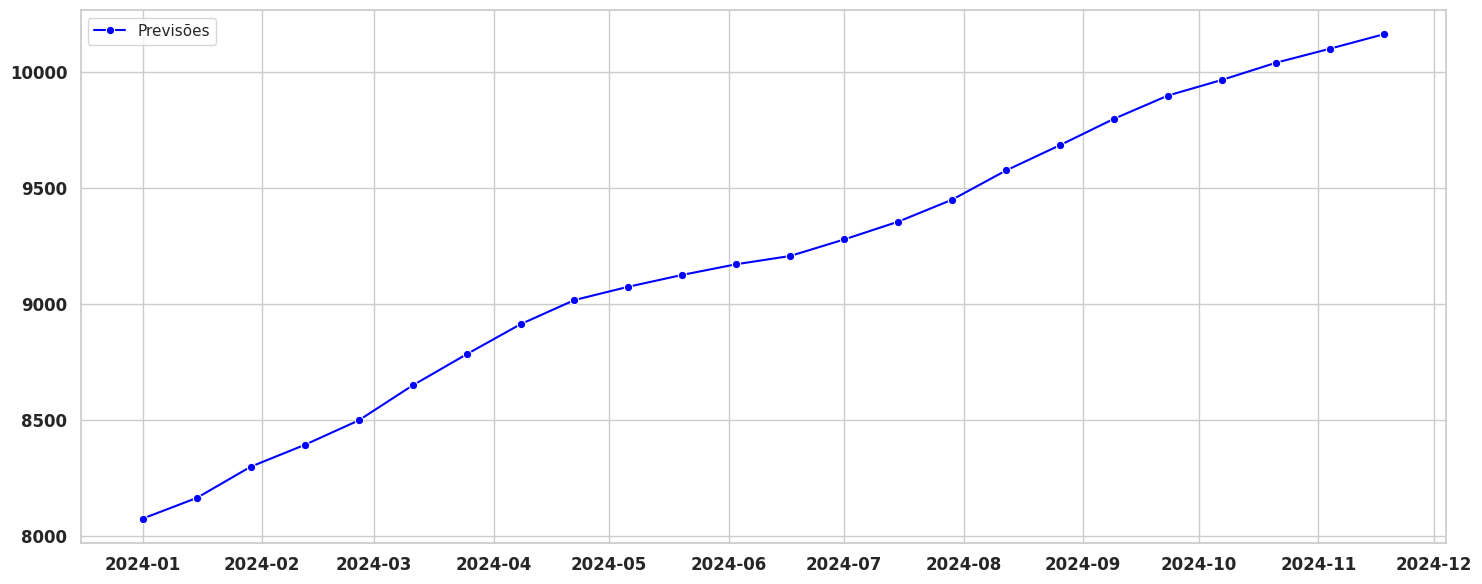

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Criar um DataFrame com os dados
df = pd.DataFrame({
    'Meses': pd.date_range(start='2024-01-01', end='2024-12-01', freq='14D'),
    'Previsões': mean_future_pred
})

# Configurar o estilo do seaborn
sns.set(style='whitegrid')

# Criar o lineplot
plt.figure(figsize=(15, 6))
sns.lineplot(x='Meses', y='Previsões', data=df, marker='o', color='blue', label='Previsões')

# Adicionar rótulos e título
plt.xlabel('', fontweight='bold')
plt.ylabel('', fontweight='bold')
plt.title('', fontweight='bold')

# Ajustar o tamanho e a negrito dos ticks no eixo x e y
plt.xticks(rotation=0, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12
, fontweight='bold')

# Exibir o gráfico
plt.tight_layout()
plt.show()